In [1]:
import numpy
import pandas
import seaborn
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

c:\Users\Utilizador\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Descrição do Dataset

De modo a se poder aplicar corretamente um modelo de machine learning é necessário primeiro analisar e limpar o dataset que nos foi providenciado pelos docentes da disciplina. Este dataset contém dados relativos à intensidade de incidentes na em Guimarães durante um certo período de tempo. Os atributos que podemos encontrar são:

* magnitude_of_delay
* delay_in_seconds
* affected_roads
* record_date
* luminosity
* avg_temperature
* avg_atm_pressure
* avg_humidity
* avg_wind_speed
* avg_precipitation
* avg_rain
* incidents


### Objetivo

Feita uma análise ao dataset pode-se concluir que o atributo que é necessário utilizar para que o modelo seja capaz de prever a intensidade de acidentes de transito é o **incidents**.

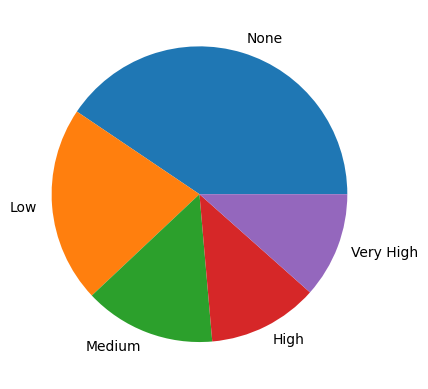

Distribuição percentual de Incidents.
None         40.56
High         21.46
Low          14.36
Very High    12.06
Medium       11.56
Name: incidents, dtype: float64


In [2]:
testing = pandas.read_csv('../../Datasets/Incidents/training_data.csv', encoding='iso-8859-1', keep_default_na=False)
testing.columns = testing.columns.str.lower()

testing['incidents'] = testing['incidents'].map({'None':0, 'Low':1, 'Medium':2, 'High':3, 'Very_High':4})

percentage_distribution = testing['incidents'].value_counts(normalize=True) * 100
labels = ['None', 'Low', 'Medium', 'High', 'Very High']
plt.pie(percentage_distribution, labels=labels)
plt.show()

print('Distribuição percentual de Incidents.')
percentage_distribution.index = percentage_distribution.index.map({0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'})
print(percentage_distribution)

## Análise do *incidents*

Como se pode observar no gráfico anterior, o atributo é composto pelos parâmetros **None**, **Low**, **Medium**, **High** e **Very_High** que definem a intensidade de incidentes. Estes parâmetros constituem a escala que será utilizada nas previsões.
    
Através do gráfico pode-se elaborar uma ideia dos incidentes que acontecem ao longo do dia. Por exemplo, a maior percentagem corresponde a **None**, cerca de 40%. Com isto, pode-se concluir que existem bastantes períodos do dia em que não existe qualquer tipo de incidente. Já no caso do **Very_High**, com percentagem de 12%, conclui-se que é referente a períodos do dia como no inicio da manhã e o final de tarde nos quais existe uma intensidade de trânsito mais elevada e uma probabilidade maior de incidentes.


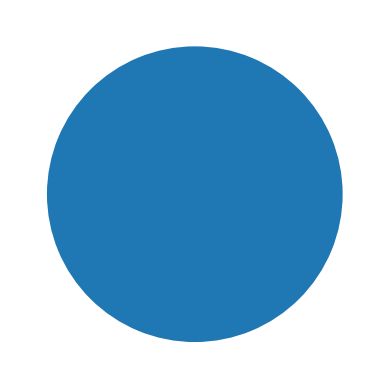

In [3]:
avg_precipitation = testing['avg_precipitation'].value_counts(normalize=True) * 100
plt.pie(avg_precipitation)
plt.show()

In [4]:
testing = (testing[testing['affected_roads'] != ","])


testing.drop(['avg_precipitation'], inplace=True, axis=1)

In [5]:
class IncidentData:
    def process(filename, encoding) -> pandas.DataFrame:
        # Load the csv files
        data = pandas.read_csv('../../Datasets/Incidents/' + filename, 
                                encoding=encoding, 
                                keep_default_na=False)
    
        data.columns = data.columns.str.lower()
        
        data['record_date'] = data.record_date.map(lambda x : parser.parse(x))
        data['week_day'] = data.record_date.map(lambda x : x.weekday())
        data['day'] = data.record_date.map(lambda x : x.day)
        data['month'] = data.record_date.map(lambda x : x.month)
        data['hour'] = data.record_date.map(lambda x : x.hour)
        data.drop('record_date', inplace=True, axis=1)

        data.luminosity = data.luminosity.map({'DARK': 0, 'LOW_LIGHT': 1, 'LIGHT': 2})
        if 'incidents' in data.columns:
            data.incidents = data.incidents.map({'None':0,
                                                 'Low':1, 
                                                 'Medium':2, 
                                                 'High':3, 
                                                 'Very_High':4})

        data['avg_rain'].fillna(0, inplace=True)

        data.avg_rain = data.avg_rain.map({'Sem Chuva':0, 
                                           'chuva moderada':1, 
                                           'chuva fraca':2, 
                                           'chuva forte': 3})

        data['magnitude_of_delay'] = data['magnitude_of_delay'].map({'UNDEFINED': 0,
                                                                     'MAJOR': 1})
        
        ar_list = data.affected_roads.str.split(",").map(lambda x: 
                                                            len(list(filter(None, x)))
                                                        )

        data['affected_roads'] = ar_list

        data.drop('city_name', inplace=True, axis=1)

        data.drop('avg_precipitation', inplace=True, axis=1)

        data.drop('avg_rain', inplace=True, axis=1)
        
        data.drop('month', inplace=True, axis=1)
        
        return data

In [6]:
training_data = IncidentData.process('training_data.csv', 'iso-8859-1')
test_data = IncidentData.process('test_data.csv','iso-8859-1')
training_data["id"] = training_data.index + 1
test_data["id"] = test_data.index + 1 

training_data.head()

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,incidents,week_day,day,hour,id
0,0.0,0,0,0,12.0,1013.0,70.0,1.0,0,0,15,23,1
1,0.0,385,1,0,12.0,1007.0,91.0,1.0,0,5,25,18,2
2,0.0,69,0,2,14.0,1025.0,64.0,0.0,1,4,12,15,3
3,1.0,2297,11,2,15.0,1028.0,75.0,1.0,4,2,29,9,4
4,0.0,0,5,2,27.0,1020.0,52.0,1.0,3,6,13,11,5


In [7]:
training_data.describe()

,magnitude_of_delay,delay_in_seconds,affected_roads,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,incidents,week_day,day,hour,id
count,4992.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.135817,560.567000,5.295800,0.967200,14.583000,1018.145000,74.455000,1.253500,1.5010,2.983600,15.888400,11.404800,2500.500000
std,0.342629,1686.859581,4.247718,0.980773,4.820514,5.174372,17.204638,1.269847,1.4881,1.992015,8.734736,6.910404,1443.520003
min,0.000000,0.000000,0.000000,0.000000,1.000000,997.000000,6.000000,0.000000,0.0000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,5.000000,0.000000,11.000000,1015.000000,63.000000,0.000000,0.0000,1.000000,8.000000,5.000000,1250.750000
50%,0.000000,0.000000,5.000000,1.000000,14.000000,1019.000000,78.000000,1.000000,1.0000,3.000000,16.000000,11.000000,2500.500000
75%,0.000000,234.000000,6.000000,2.000000,18.000000,1022.000000,90.000000,2.000000,3.0000,5.000000,23.000000,17.000000,3750.250000
max,1.000000,31083.000000,46.000000,2.000000,35.000000,1032.000000,100.000000,10.000000,4.0000,6.000000,31.000000,23.000000,5000.000000


<AxesSubplot:xlabel='incidents', ylabel='delay_in_seconds'>

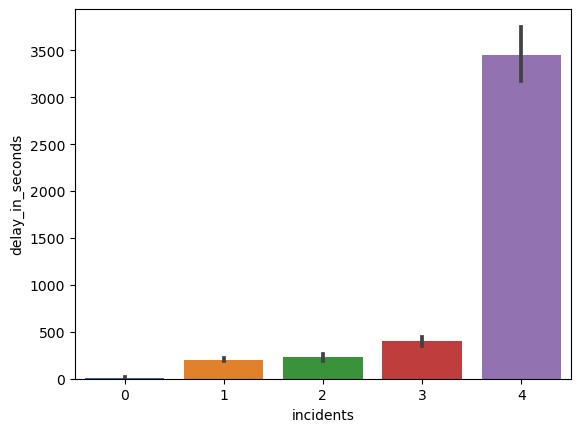

In [8]:
seaborn.barplot(x='incidents', y='delay_in_seconds', data=training_data)

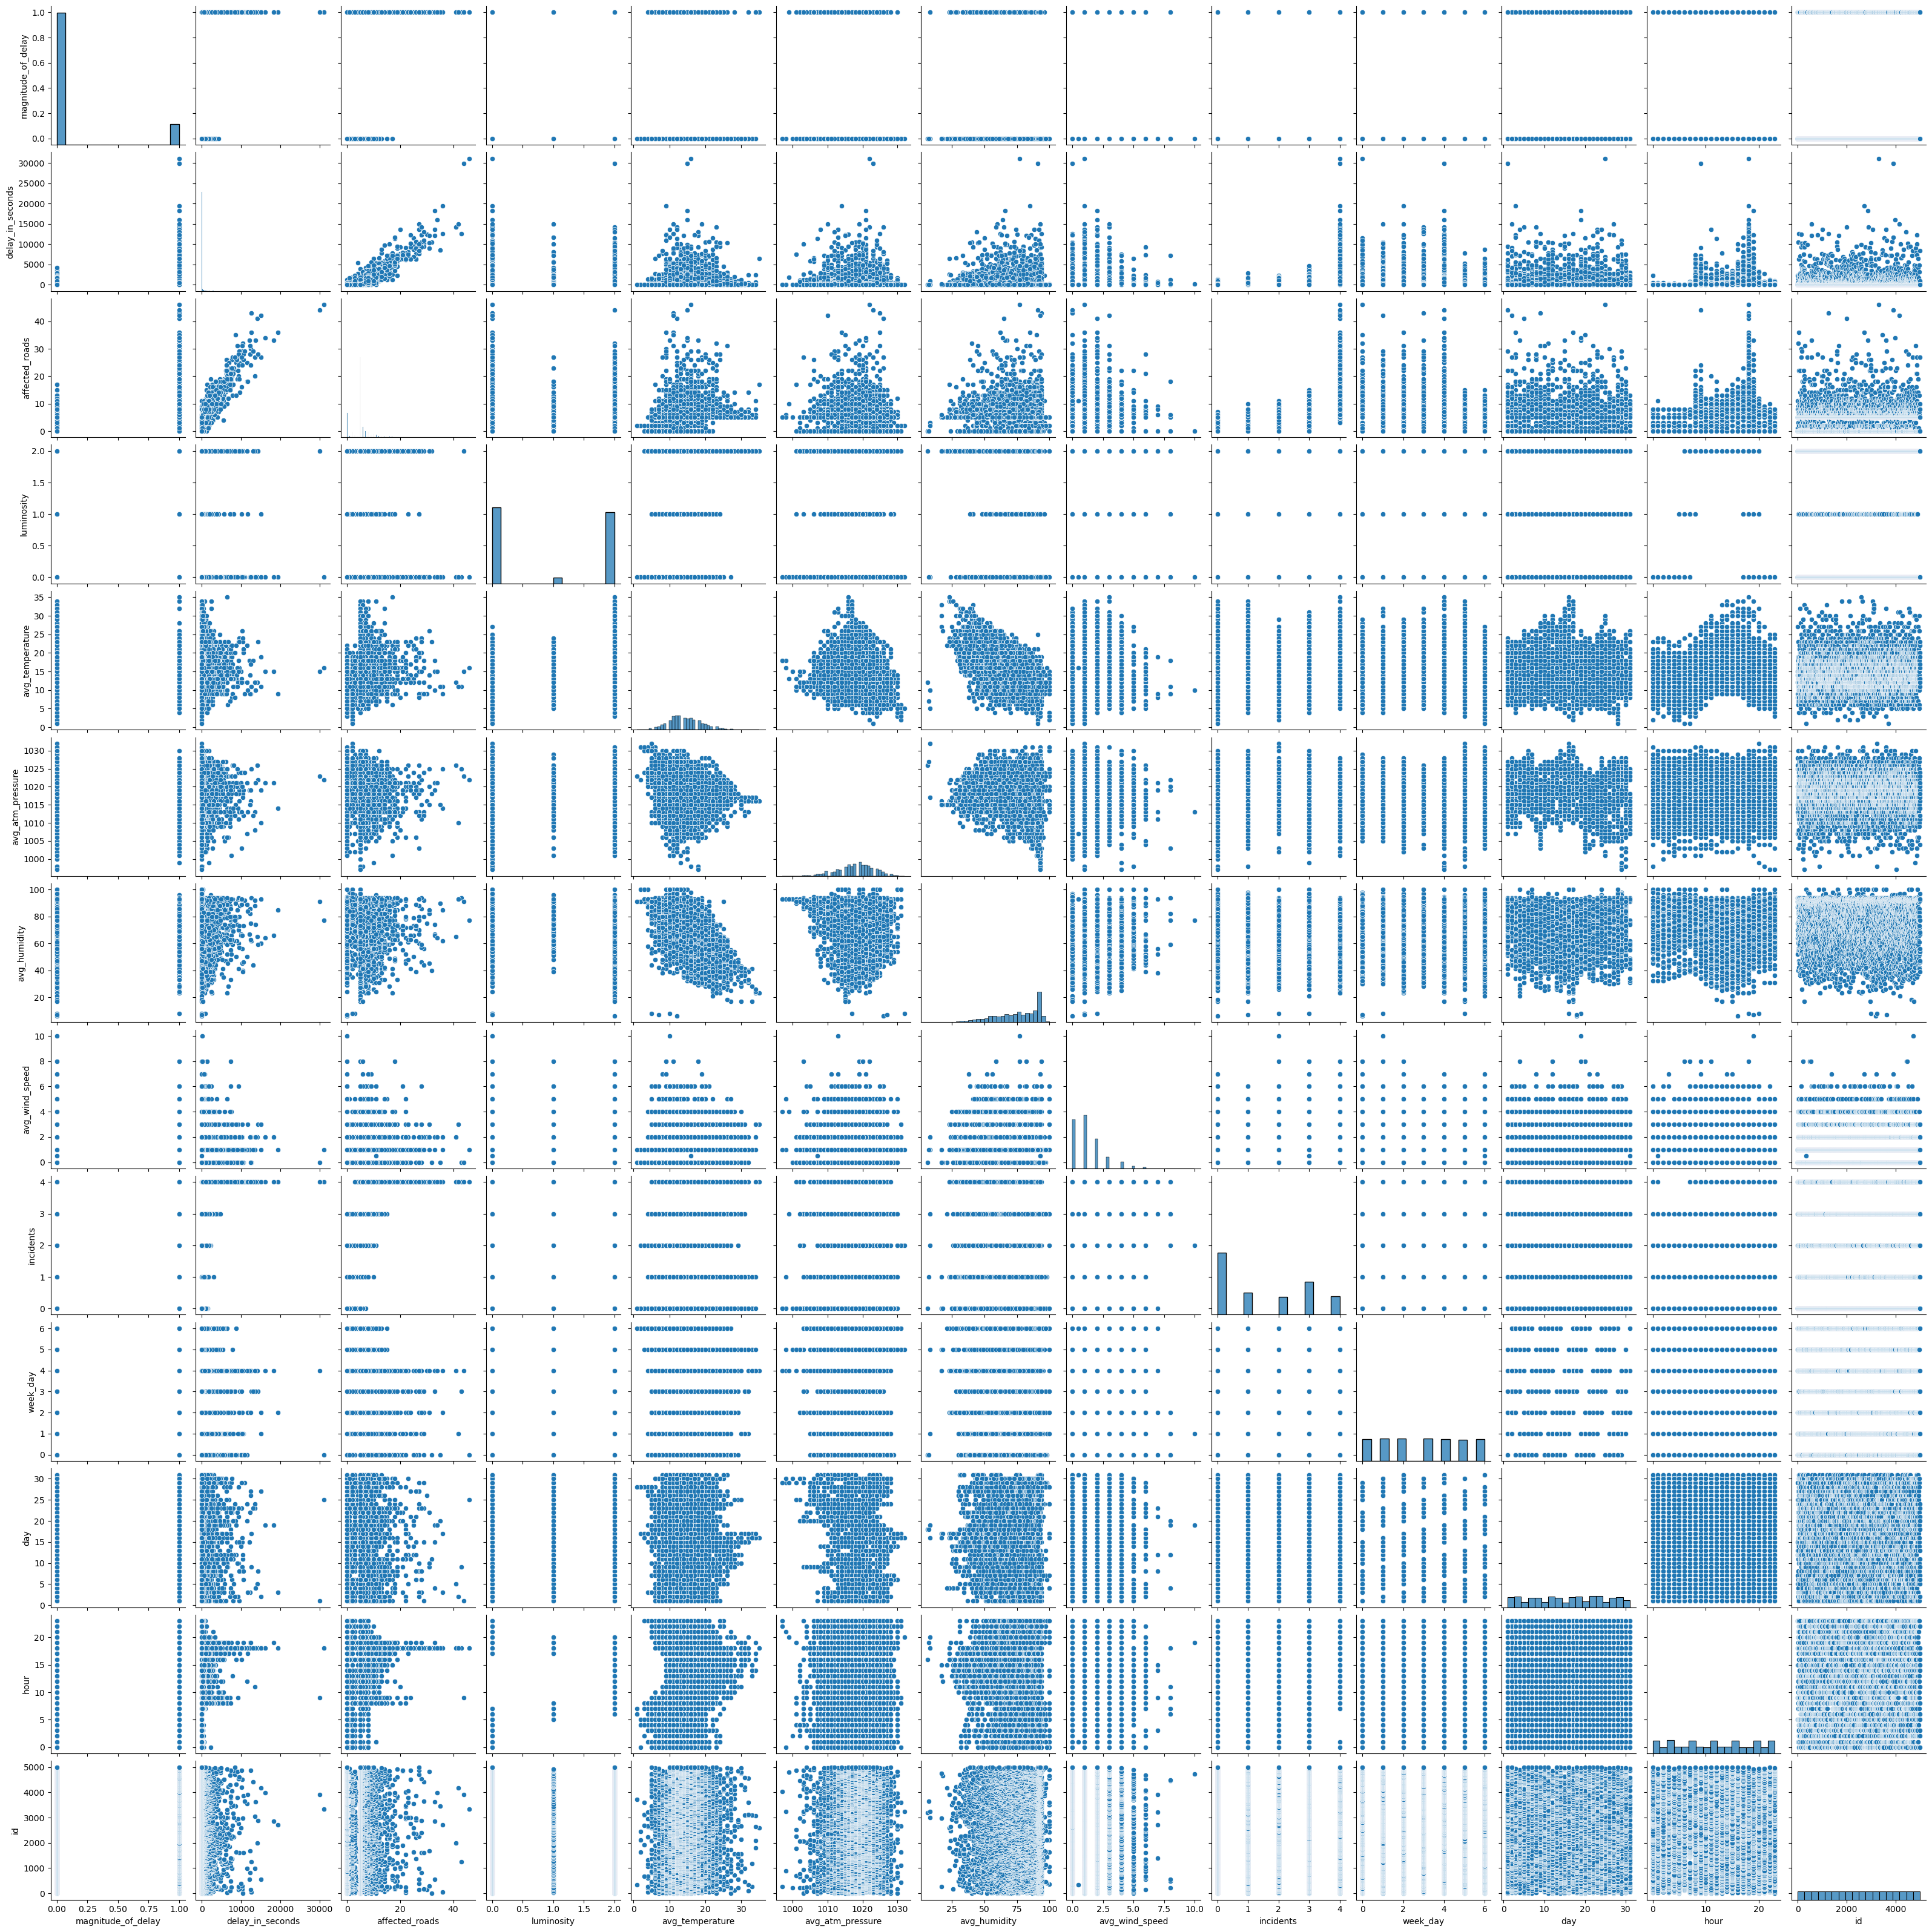

In [9]:
seaborn.pairplot(training_data)

<AxesSubplot:>

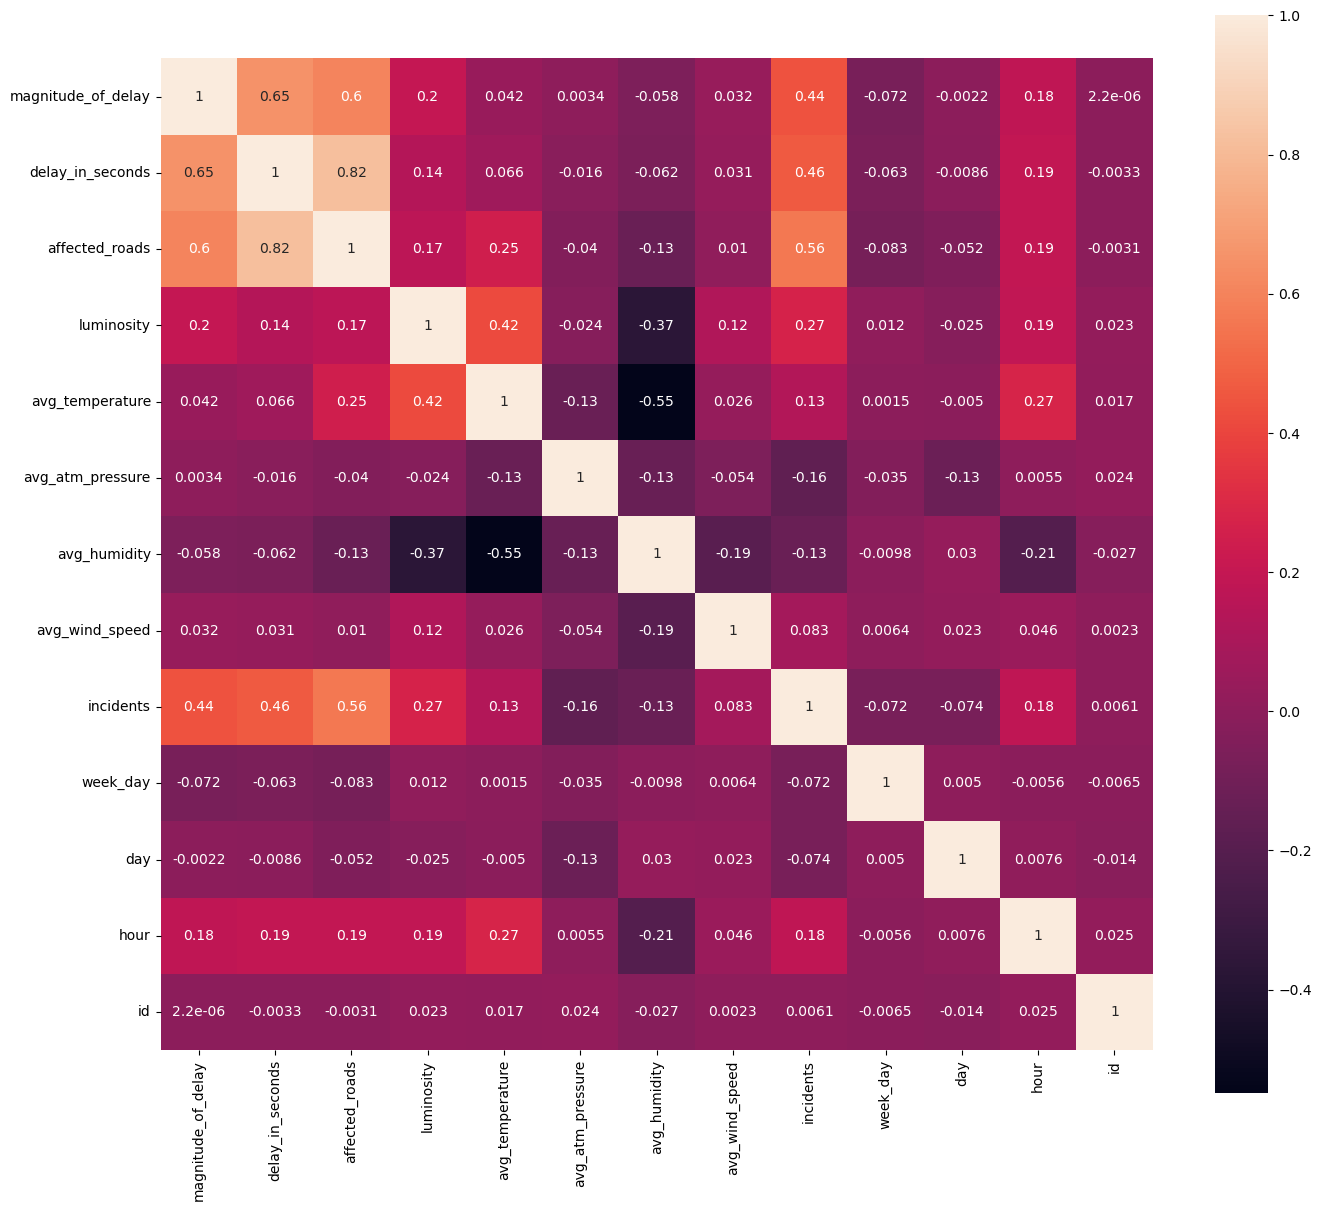

In [10]:
correlations = training_data.corr()
f,ax = plt.subplots(figsize = (16,14))
seaborn.heatmap(correlations, vmax=1, square=True, annot=True)

In [11]:
y_target = training_data.incidents.values
x = training_data.drop('incidents', axis=1)
y = training_data[['incidents']]

In [12]:
x_train = x.drop(['id'], axis=1)
x_test = test_data.drop(['id'], axis=1)

In [13]:
XGB = xgb.XGBClassifier(n_estimators=2500, max_depth=7, learning_rate=0.01, subsample=0.7, colsample_bytree=1)
model_gradBoosting = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=4, subsample=0.5)

In [14]:
XGB.fit(x_train, y_target)

c:\Users\Utilizador\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\Users\Utilizador\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:15:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2500, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

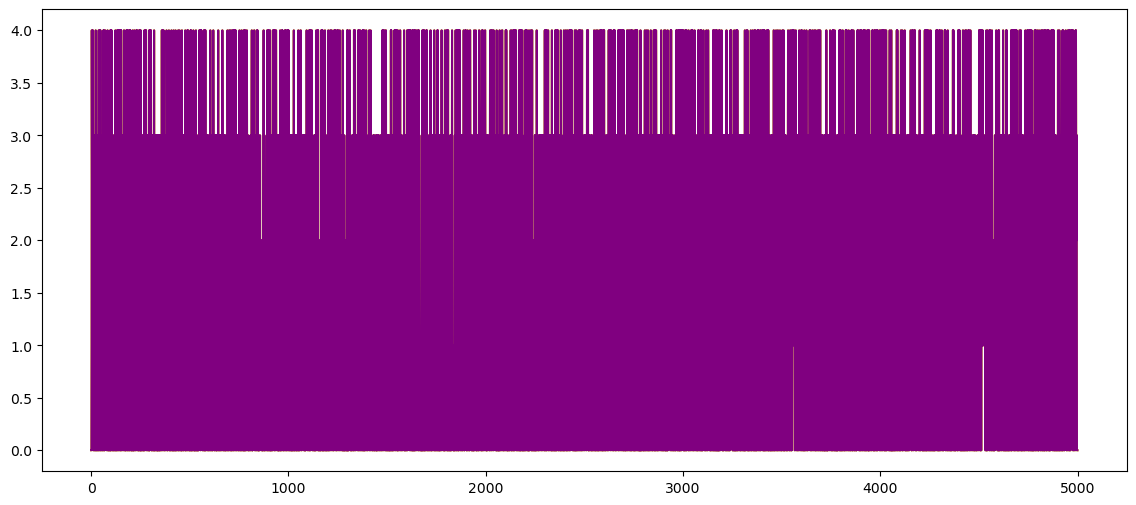

In [15]:
model_xgboost = XGB.predict(x_train)
plt.figure(figsize=(14,6))
plt.plot(y, color='yellow')
plt.plot(model_xgboost, color='purple')
plt.show()

In [16]:
predict_test = XGB.predict(x_test)

In [17]:
# teste = numpy.ndarray.round(predict_test)
#teste[teste==0.] = 0
teste = predict_test
teste = numpy.where(teste ==0, "None", teste)
teste = numpy.where(teste =="1", "Low", teste)
teste = numpy.where(teste =="2", "Medium", teste)
teste = numpy.where(teste =="3", "High", teste)
teste = numpy.where(teste =="4", "Very_High", teste)


In [18]:
pandas.DataFrame({"RowId":test_data["id"],"incidents": teste}).to_csv(f'../../Predictions/Incidents/predict_test_sale_xgboost.csv',index=False)